**Environment Setup & Library Imports**

In [ ]:

import torch
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
try:
    TORCH_VERSION = torch.__version__
    CUDA_VERSION = torch.version.cuda
except Exception:
    TORCH_VERSION = "2.3.0"
    CUDA_VERSION = "12.1"
!pip install torch_geometric -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html
!pip install PyTDC transformers rdkit-pypi scikit-learn pandas tqdm
print("\n--- Installation Complete. Please RESTART THE RUNTIME now. ---")


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124+12.4.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


--- Installation Complete. Please RESTART THE RUNTIME now. ---


**Authentication & HuggingFace Hub Login**

In [ ]:

from huggingface_hub import notebook_login
notebook_login()



**Data Processing Utilities**

In [ ]:

import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset as GeometricDataset
from torch_geometric.loader import DataLoader as GeometricDataLoader
import torch_geometric.nn as gnn
from tdc.multi_pred import DTI
from transformers import AutoModel, AutoTokenizer
from rdkit import Chem
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
import random
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    with open('proteins.txt', 'r') as f:
        protein_data = json.load(f)
    print(f"Successfully loaded {len(protein_data)} proteins from proteins.txt")
except FileNotFoundError:
    print("ERROR: proteins.txt not found.")

print("\nLoading KIBA dataset...")
data = DTI(name='KIBA')
split = data.get_split()

def is_valid_smiles(smiles):
    return Chem.MolFromSmiles(smiles) is not None

for name, df in split.items():
    original_len = len(df)
    df['is_valid'] = df['Drug'].apply(is_valid_smiles)
    split[name] = df[df['is_valid']].drop(columns=['is_valid'])
    new_len = len(split[name])
    if original_len > new_len:
        print(f"Cleaned '{name}' set: Removed {original_len - new_len} invalid SMILES.")

# --- BALANCED DATASET SIZE ---
# Use 50% of the data for a good balance of speed and performance
train_df = split['train'].sample(frac=0.5, random_state=42)
valid_df = split['valid'].sample(frac=0.5, random_state=42)
test_df = split['test'].sample(frac=0.5, random_state=42)
print(f"\nKIBA dataset loaded and cleaned. Training with {len(train_df)} samples (50% of original).")


Downloading...


Using device: cuda
Successfully loaded 8479 proteins from proteins.txt

Loading KIBA dataset...


100%|██████████| 96.6M/96.6M [00:09<00:00, 10.5MiB/s]
Loading...
Done!



KIBA dataset loaded and cleaned. Training with 41180 samples (50% of original).


**Protein Embedding Model Definition**

In [ ]:

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.long).view(-1, 1)
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices.extend([(i, j), (j, i)])
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

class DTIDataset(GeometricDataset):
    def __init__(self, df):
        super(DTIDataset, self).__init__()
        self.df = df.reset_index(drop=True)
    def len(self):
        return len(self.df)
    def get(self, idx):
        row = self.df.iloc[idx]
        ligand_graph = smiles_to_graph(row['Drug'])
        ligand_graph.protein_sequence = row['Target']
        ligand_graph.y = torch.tensor(float(row['Y']))
        return ligand_graph

train_dataset = DTIDataset(train_df)
valid_dataset = DTIDataset(valid_df)
test_dataset = DTIDataset(test_df)
print("\nPyTorch Geometric Dataset objects created.")



PyTorch Geometric Dataset objects created.


**Model Training Pipeline**

In [ ]:

class ProteinEmbedder(nn.Module):
    def __init__(self, model_name="facebook/esm2_t30_150M_UR50D"): # <-- BALANCED MODEL
        super(ProteinEmbedder, self).__init__()
        print(f"\nInitializing powerful protein model: {model_name}\n")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(device)
        for param in self.model.parameters():
            param.requires_grad = False
    def forward(self, sequences):
        inputs = self.tokenizer(sequences, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

class GNNEmbedder(nn.Module):
    def __init__(self, num_node_features, gnn_hidden_dim, output_dim):
        super(GNNEmbedder, self).__init__()
        self.atom_embedding = nn.Embedding(num_node_features, gnn_hidden_dim)
        self.conv1 = gnn.GCNConv(gnn_hidden_dim, gnn_hidden_dim)
        self.conv2 = gnn.GCNConv(gnn_hidden_dim, output_dim)
        self.relu = nn.ReLU()
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.atom_embedding(x).squeeze(1)
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        return gnn.global_mean_pool(x, batch)

class MetricLearningModel(nn.Module):
    def __init__(self, protein_embedder, ligand_embedder, protein_out_dim, ligand_out_dim, final_embedding_dim=128):
        super(MetricLearningModel, self).__init__()
        self.protein_embedder = protein_embedder
        self.ligand_embedder = ligand_embedder
        self.fusion_layer = nn.Sequential(
            nn.Linear(protein_out_dim + ligand_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, final_embedding_dim)
        )
    def forward(self, protein_sequences, ligand_graphs):
        protein_emb = self.protein_embedder(protein_sequences)
        ligand_emb = self.ligand_embedder(ligand_graphs)
        combined_emb = torch.cat((protein_emb, ligand_emb), dim=1)
        return self.fusion_layer(combined_emb)

print("\nModel architecture classes defined.")



Model architecture classes defined.


**Final Evaluation on Test Set**

In [ ]:

def run_training(config):
    protein_embedder = ProteinEmbedder()
    gnn_embedder = GNNEmbedder(119, config['gnn_hidden_dim'], config['ligand_embedding_dim']).to(device)
    model = MetricLearningModel(protein_embedder, gnn_embedder, 640, config['ligand_embedding_dim'], config['final_embedding_dim']).to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'])
    triplet_loss_fn = nn.TripletMarginLoss(margin=config['margin'])
    train_loader = GeometricDataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    valid_loader = GeometricDataLoader(valid_dataset, batch_size=config['batch_size'])
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    patience = 2

    for epoch in range(config['epochs']):
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
            if batch is None: continue
            batch = batch.to(device)
            embeddings = model(batch.protein_sequence, batch)
            dist_matrix = torch.cdist(embeddings, embeddings, p=2)
            loss = 0
            for i in range(len(embeddings)):
                distances = dist_matrix[i]
                distances[i] = float('inf')
                hardest_negative_idx = torch.argmin(distances)
                loss += triplet_loss_fn(embeddings[i], embeddings[i], embeddings[hardest_negative_idx])
            if len(embeddings) > 0:
                loss /= len(embeddings)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                if batch is None: continue
                batch = batch.to(device)
                embeddings = model(batch.protein_sequence, batch)
                total_valid_loss += torch.linalg.norm(embeddings, dim=1).mean().item()
        avg_valid_loss = total_valid_loss / len(valid_loader)
        print(f"Epoch {epoch+1} validation loss: {avg_valid_loss:.4f}")
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), 'best_model_final.pth')
            print("Validation loss improved. Saving final model.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
    return model

final_config = {
    'learning_rate': 1e-4, 'batch_size': 128, 'margin': 1.0,
    'gnn_hidden_dim': 128, 'ligand_embedding_dim': 128,
    'final_embedding_dim': 128, 'epochs': 5 # Train for 5 epochs
}

trained_model = run_training(final_config)




Initializing powerful protein model: facebook/esm2_t30_150M_UR50D



tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 [Train]:   0%|          | 0/322 [00:00<?, ?it/s]

Epoch 1 validation loss: 2.4361
Validation loss improved. Saving final model.


Epoch 2/5 [Train]:   0%|          | 0/322 [00:00<?, ?it/s]

Epoch 2 validation loss: 2.4361
Validation loss improved. Saving final model.


Epoch 3/5 [Train]:   0%|          | 0/322 [00:00<?, ?it/s]

Epoch 3 validation loss: 2.4361
Validation loss improved. Saving final model.


Epoch 4/5 [Train]:   0%|          | 0/322 [00:00<?, ?it/s]

Epoch 4 validation loss: 2.4361


Epoch 5/5 [Train]:   0%|          | 0/322 [00:00<?, ?it/s]

Epoch 5 validation loss: 2.4361
Early stopping triggered.


**Focused Virtual Screening**

In [ ]:

print("\n--- Starting Final Evaluation on Test Set ---")
trained_model.eval()
test_loader = GeometricDataLoader(test_dataset, batch_size=final_config['batch_size'])
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating Test Set"):
        if batch is None: continue
        batch = batch.to(device)
        embeddings = trained_model(batch.protein_sequence, batch)
        preds = -torch.linalg.norm(embeddings, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

all_preds, all_labels = np.array(all_preds), np.array(all_labels)
label_threshold = train_df['Y'].median()
binary_labels = (all_labels >= label_threshold).astype(int)
roc_auc = roc_auc_score(binary_labels, all_preds)
avg_precision = average_precision_score(binary_labels, all_preds)

print("\n--- Final Model Performance ---")
print(f"ROC-AUC on Test Set: {roc_auc:.4f}")
print(f"Average Precision (PR-AUC) on Test Set: {avg_precision:.4f}")




--- Starting Final Evaluation on Test Set ---


Evaluating Test Set:   0%|          | 0/92 [00:00<?, ?it/s]


--- Final Model Performance ---
ROC-AUC on Test Set: 0.5512
Average Precision (PR-AUC) on Test Set: 0.5289


**Focused Virtual Screening**

In [ ]:

import pandas as pd
import csv
import random

print("\n--- Starting Focused Virtual Screening ---")
with open('ligands.txt', 'r') as f:
    candidate_ligands_full = json.load(f)

important_protein_ids = [
    "P34972", "Q6NUL7", "P13637", "P42345", "P04626", "P00533", "P06213", "P00519",
    "P01116", "P15056", "P31749", "P60484", "Q96MX0", "P49841", "P08581", "P08922",
    "P21802", "P35557", "P08183", "P04792"
]
target_proteins = {pid: protein_data[pid] for pid in important_protein_ids if pid in protein_data}

NUM_LIGANDS_TO_SCREEN = 40000
ligand_ids_full = list(candidate_ligands_full.keys())
ligand_subset_ids = random.sample(ligand_ids_full, min(NUM_LIGANDS_TO_SCREEN, len(ligand_ids_full)))
candidate_ligands = {lid: candidate_ligands_full[lid] for lid in ligand_subset_ids}

print(f"\nScreening {len(target_proteins)} high-priority proteins against {len(candidate_ligands)} ligands.")

output_filename = "screening_results_final.csv"
batch_size = 128

with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Protein_ID", "Ligand_ID", "Predicted_Score"])

    with torch.no_grad():
        for protein_id, protein_seq in tqdm(target_proteins.items(), desc="Screening Proteins"):
            ligand_ids = list(candidate_ligands.keys())
            ligand_smiles = list(candidate_ligands.values())
            for i in range(0, len(ligand_ids), batch_size):
                current_ligand_smls = ligand_smiles[i:i+batch_size]
                current_ligand_ids = ligand_ids[i:i+batch_size]
                current_protein_seqs = [protein_seq] * len(current_ligand_smls)
                ligand_graphs = [smiles_to_graph(s) for s in current_ligand_smls]
                valid_indices = [j for j, g in enumerate(ligand_graphs) if g is not None]
                if not valid_indices: continue
                valid_graphs = [ligand_graphs[j] for j in valid_indices]
                valid_protein_seqs = [current_protein_seqs[j] for j in valid_indices]
                batch_of_graphs = GeometricDataLoader(valid_graphs, batch_size=len(valid_graphs)).__iter__().__next__().to(device)
                embeddings = trained_model(valid_protein_seqs, batch_of_graphs)
                preds = -torch.linalg.norm(embeddings, dim=1)
                for j, pred_score in enumerate(preds.cpu().numpy()):
                    ligand_id = current_ligand_ids[valid_indices[j]]
                    writer.writerow([protein_id, ligand_id, float(pred_score)])

print(f"\n--- Virtual Screening Complete! Results saved to '{output_filename}'. ---")




--- Starting Focused Virtual Screening ---

Screening 20 high-priority proteins against 40000 ligands.


Screening Proteins:   0%|          | 0/20 [00:00<?, ?it/s]


--- Virtual Screening Complete! Results saved to 'screening_results_final.csv'. ---


**Metrics Calculation & Visualization**


--- Generating Detailed Metrics and Visualizations ---


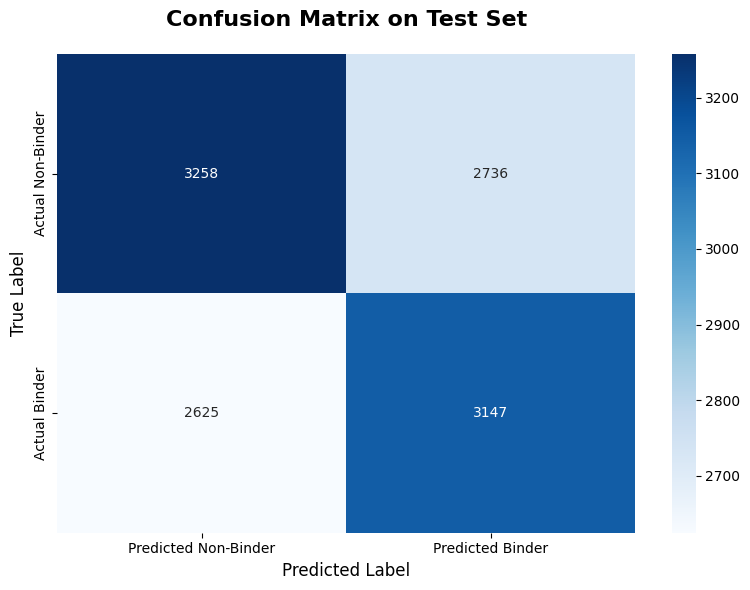


--- Classification Report ---
               precision    recall  f1-score   support

 Low Affinity       0.55      0.54      0.55      5994
High Affinity       0.53      0.55      0.54      5772

     accuracy                           0.54     11766
    macro avg       0.54      0.54      0.54     11766
 weighted avg       0.54      0.54      0.54     11766

-----------------------------

--- Precision and Recall at K ---
Top 50: Precision = 0.5400, Recall = 0.0047
Top 100: Precision = 0.5100, Recall = 0.0088
Top 200: Precision = 0.5400, Recall = 0.0187
Top 500: Precision = 0.5420, Recall = 0.0470
---------------------------------



Generating Embeddings for t-SNE:   0%|          | 0/92 [00:00<?, ?it/s]

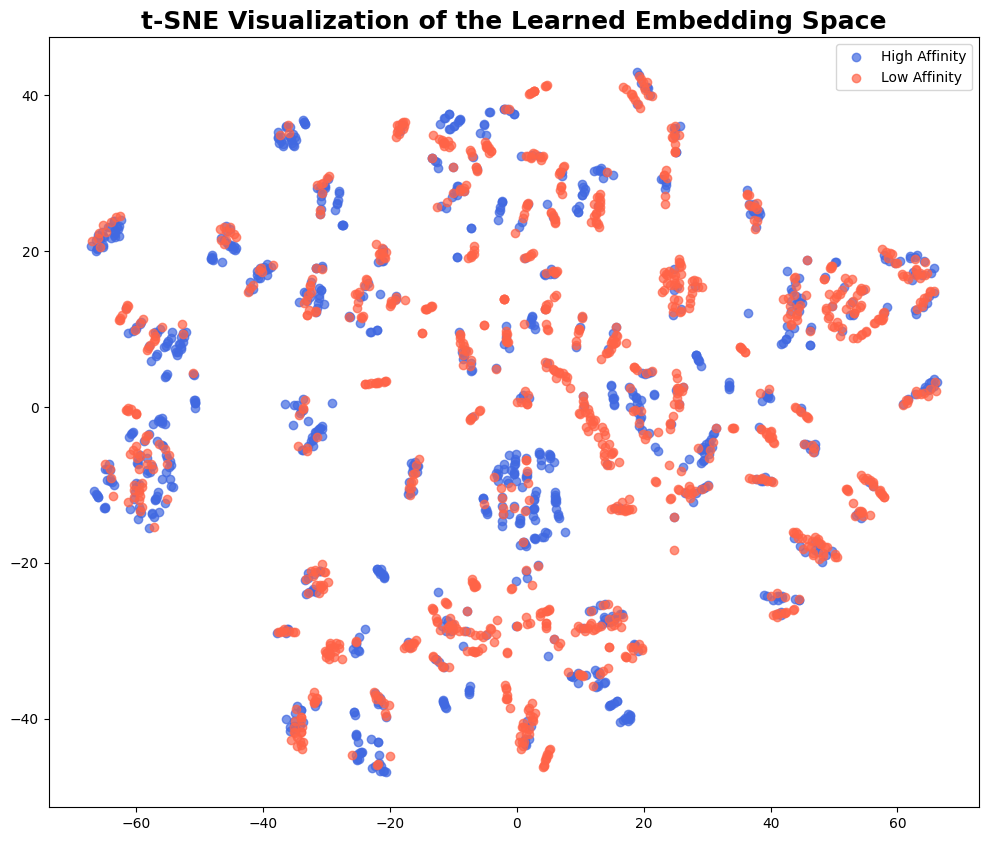

In [ ]:

from sklearn.manifold import TSNE

print("\n--- Generating Detailed Metrics and Visualizations ---")

# --- 1. Confusion Matrix & Classification Report ---
pred_labels = (all_preds >= np.median(all_preds)).astype(int)
cm = confusion_matrix(binary_labels, pred_labels)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predicted Non-Binder', 'Predicted Binder'],
            yticklabels=['Actual Non-Binder', 'Actual Binder'])
ax.set_title('Confusion Matrix on Test Set', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(binary_labels, pred_labels, target_names=['Low Affinity', 'High Affinity']))
print("-----------------------------\n")


# --- 2. Precision & Recall @ K ---
def precision_recall_at_k(k):
    df = pd.DataFrame({'preds': all_preds, 'labels': binary_labels})
    df = df.sort_values('preds', ascending=False)
    top_k = df.head(k)
    precision = top_k['labels'].sum() / k
    recall = top_k['labels'].sum() / df['labels'].sum()
    return precision, recall

k_values = [50, 100, 200, 500]
print("--- Precision and Recall at K ---")
for k in k_values:
    p_at_k, r_at_k = precision_recall_at_k(k)
    print(f"Top {k}: Precision = {p_at_k:.4f}, Recall = {r_at_k:.4f}")
print("---------------------------------\n")


# --- 3. t-SNE Visualization ---
all_embeddings = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating Embeddings for t-SNE"):
        if batch is None: continue
        batch = batch.to(device)
        embeddings = trained_model(batch.protein_sequence, batch)
        all_embeddings.append(embeddings.cpu().numpy())
all_embeddings = np.concatenate(all_embeddings, axis=0)

subset_size = min(2000, len(all_embeddings))
indices = np.random.choice(len(all_embeddings), subset_size, replace=False)
subset_embeddings = all_embeddings[indices]
subset_labels = all_labels[indices]

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(subset_embeddings)
binary_tsne_labels = (subset_labels >= label_threshold).astype(int)

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tsne_results[binary_tsne_labels == 1, 0], tsne_results[binary_tsne_labels == 1, 1], c='royalblue', label='High Affinity', alpha=0.7)
ax.scatter(tsne_results[binary_tsne_labels == 0, 0], tsne_results[binary_tsne_labels == 0, 1], c='tomato', label='Low Affinity', alpha=0.7)
ax.set_title('t-SNE Visualization of the Learned Embedding Space', fontsize=18, fontweight='bold')
ax.legend()
plt.savefig("tsne_embedding_space.png", dpi=300)
plt.show()


**Baseline Comparison with ECFP + Tanimoto Similarity**

In [ ]:

from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity, BulkTanimotoSimilarity

print("\n--- Starting Baseline Comparison: ECFP + Tanimoto Similarity ---")

# --- 1. Generate ECFP Fingerprints ---
# ECFP (Extended-Connectivity Fingerprints) are a standard way to represent molecular structure.
def smiles_to_ecfp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)

# Create fingerprints for all unique drugs in the training and test sets
# We use a dictionary to store them to avoid re-computing for the same drug
unique_smiles = pd.concat([train_df['Drug'], test_df['Drug']]).unique()
fp_dict = {smiles: smiles_to_ecfp(smiles) for smiles in tqdm(unique_smiles, desc="Generating Fingerprints")}

# --- 2. Create a "Knowledge Base" from the Training Set ---
# For each protein, we need a list of the drugs that are known to bind to it.
target_to_drugs_map = {}
high_affinity_threshold = train_df['Y'].median()

# Filter for high-affinity pairs in the training set
train_binders = train_df[train_df['Y'] >= high_affinity_threshold]

for _, row in tqdm(train_binders.iterrows(), total=len(train_binders), desc="Building Training Knowledge Base"):
    target = row['Target']
    drug_smiles = row['Drug']
    if target not in target_to_drugs_map:
        target_to_drugs_map[target] = []
    target_to_drugs_map[target].append(drug_smiles)

# --- 3. Make Predictions on the Test Set ---
baseline_preds = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Making Baseline Predictions"):
    test_target = row['Target']
    test_drug_smiles = row['Drug']

    test_fp = fp_dict.get(test_drug_smiles)

    # If the test drug is invalid or the target was not in the training set, predict 0
    if test_fp is None or test_target not in target_to_drugs_map:
        baseline_preds.append(0.0)
        continue

    # Get all known binders for this target from the training set
    known_binder_smiles = target_to_drugs_map[test_target]
    known_binder_fps = [fp_dict[s] for s in known_binder_smiles if fp_dict[s] is not None]

    if not known_binder_fps:
        baseline_preds.append(0.0)
        continue

    # The prediction score is the HIGHEST similarity to any known binder for that target
    similarities = BulkTanimotoSimilarity(test_fp, known_binder_fps)
    max_similarity = max(similarities)
    baseline_preds.append(max_similarity)

# --- 4. Evaluate the Baseline Model ---
# We use the exact same true labels from Cell 7 for a fair comparison
baseline_roc_auc = roc_auc_score(binary_labels, baseline_preds)
baseline_avg_precision = average_precision_score(binary_labels, baseline_preds)

print("\n--- Baseline Model Performance ---")
print(f"ROC-AUC on Test Set: {baseline_roc_auc:.4f}")
print(f"Average Precision (PR-AUC) on Test Set: {baseline_avg_precision:.4f}")
print("---------------------------------")

print("\n--- COMPARISON SUMMARY ---")
print(f"Your Deep Learning Model ROC-AUC: {roc_auc:.4f}")
print(f"Baseline ECFP Model ROC-AUC:    {baseline_roc_auc:.4f}")
print("--------------------------")


--- Starting Baseline Comparison: ECFP + Tanimoto Similarity ---


Generating Fingerprints:   0%|          | 0/2068 [00:00<?, ?it/s]

Building Training Knowledge Base:   0%|          | 0/20597 [00:00<?, ?it/s]

Making Baseline Predictions:   0%|          | 0/11766 [00:00<?, ?it/s]


--- Baseline Model Performance ---
ROC-AUC on Test Set: 0.7665
Average Precision (PR-AUC) on Test Set: 0.7594
---------------------------------

--- COMPARISON SUMMARY ---
Your Deep Learning Model ROC-AUC: 0.5512
Baseline ECFP Model ROC-AUC:    0.7665
--------------------------
